In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import fiona
from shapely.geometry import Point, shape
from gisutils import df2shp, project
from pydrograph import Nwis

### instantiate an NWIS object using a polygon shapefile of the study area
* `bbox.shp` is in UTM 83 zone 15 N
* pydrograph will automatically reproject the extent to GCS NAD83 by default (EPSG: 4269), which is the typical GCS used by NWIS. Alternatively, the NAD27 datum can be used (EPSG: 4267) by specifying `datum=NAD27` to the `NWIS()` constructor.

In [3]:
nwis = Nwis(extent='../data/bbox.shp')

reading extent from ../data/bbox.shp...
reprojecting extent from
EPSG:26915
to
EPSG:4269


### field measurements inventory table
* fetches inventory tables of all misc field measurements within the polygon

In [4]:
field_sites = nwis.get_siteinfo('field_measurements')

getting site inventory for field_measurements...
url: http://nwis.waterdata.usgs.gov/usa/nwis/measurements?nw_longitude_va=-92.700&nw_latitude_va=46.800&se_longitude_va=-92.600&se_latitude_va=46.700&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=inventory_dt&column_name=drain_area_va&column_name=contrib_drain_area_va&column_name=tz_cd&column_name=local_time_fg&column_name=reliability_cd&column_name=pro

### daily values sites inventory table

In [5]:
dv_sites = nwis.get_siteinfo('daily_values')

getting site inventory for daily_values...
url: http://nwis.waterdata.usgs.gov/usa/nwis/dv?referred_module=sw&site_tp_cd=ST&nw_longitude_va=-92.700&nw_latitude_va=46.800&se_longitude_va=-92.600&se_latitude_va=46.700&coordinate_format=decimal_degrees&group_key=NONE&format=sitefile_output&sitefile_output_format=rdb&column_name=site_no&column_name=station_nm&column_name=site_tp_cd&column_name=dec_lat_va&column_name=dec_long_va&column_name=coord_meth_cd&column_name=coord_acy_cd&column_name=coord_datum_cd&column_name=dec_coord_datum_cd&column_name=district_cd&column_name=state_cd&column_name=county_cd&column_name=country_cd&column_name=land_net_ds&column_name=map_nm&column_name=map_scale_fc&column_name=alt_va&column_name=alt_meth_cd&column_name=alt_acy_va&column_name=alt_datum_cd&column_name=huc_cd&column_name=basin_cd&column_name=topo_cd&column_name=inventory_dt&column_name=drain_area_va&column_name=contrib_drain_area_va&column_name=tz_cd&column_name=local_time_fg&column_name=reliability_c

### write shapefiles of the inventory tables
* `shapely Points` were created from the lat/lon coordinates when the tables were assembled; these are used to write the feature geometries for the shapefiles

In [6]:
df2shp(dv_sites, 'dv_sites.shp', epsg=4269)
df2shp(field_sites, 'misc_sites.shp', epsg=4269)

writing dv_sites.shp... Done
writing misc_sites.shp... Done


/Users/aleaf/mambaforge/envs/gis/lib/python3.10/site-packages/gisutils/shapefile.py:129: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  Type = g.type
/Users/aleaf/mambaforge/envs/gis/lib/python3.10/site-packages/gisutils/shapefile.py:129: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  Type = g.type


### get daily values for a list of sites

In [7]:
sites = dv_sites.site_no.tolist()[0:2]
sites

['04021520']

In [8]:
dvs = nwis.get_all_dvs(sites, start_date='1990-01-01')
dvs.keys()

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04021520&startDT=1990-01-01&parameterCd=00060


dict_keys(['04021520'])

In [9]:
dvs['04021520'].head()

,agency_cd,site_no,datetime,72604_00060_00003,72604_00060_00003_cd
datetime,,,,,
2005-05-26,USGS,04021520,2005-05-26,199,A
2005-05-27,USGS,04021520,2005-05-27,200,A:e
2005-05-28,USGS,04021520,2005-05-28,200,A
2005-05-29,USGS,04021520,2005-05-29,187,A
2005-05-30,USGS,04021520,2005-05-30,169,A


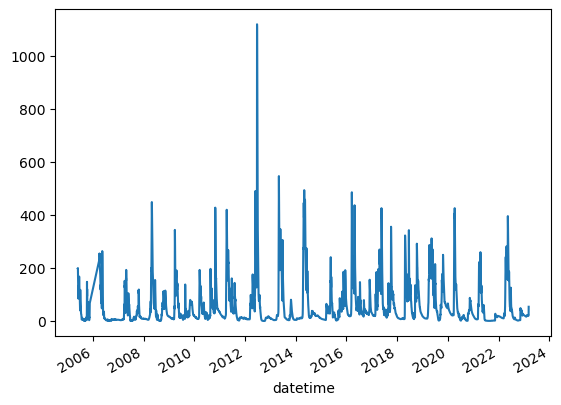

In [10]:
dvs['04021520']['Q'] = pd.to_numeric(dvs['04021520']['72604_00060_00003'], errors='coerce')
ax = dvs['04021520']['Q'].plot()

### get a single site

In [11]:
df = nwis.get_dvs('04015475')
df.head()

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04015475&startDT=1880-01-01&parameterCd=00060


,agency_cd,site_no,datetime,72578_00060_00003,72578_00060_00003_cd
datetime,,,,,
1978-09-19,USGS,04015475,1978-09-19,143.0,A
1978-09-20,USGS,04015475,1978-09-20,125.0,A
1978-09-21,USGS,04015475,1978-09-21,100.0,A
1978-09-22,USGS,04015475,1978-09-22,80.0,A
1978-09-23,USGS,04015475,1978-09-23,83.0,A


### just get the url for dvs for a site
(`start_date` is 1880-01-01 by default; `end_date` is `None` by default)

In [12]:
url = nwis.make_dv_url('04015475')
url

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04015475&startDT=1880-01-01&parameterCd=00060


'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=04015475&startDT=1880-01-01&parameterCd=00060'

## Fetch some miscellaneous measurements

In [13]:
sites = field_sites.site_no.tolist()[:5]
sites

['04021520']

In [14]:
fm = nwis.get_all_measurements(sites)

04021520
http://nwis.waterdata.usgs.gov/nwis/measurements?site_no=04021520&agency_cd=USGS&format=rdb


/Users/aleaf/Documents/GitHub/pydrograph/pydrograph/nwis.py:609: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.log = pd.concat([self.log,


In [15]:
fm.head()

agency_cd   site_no  measurement_nu  \
site_no  datetime                                                  
04021520 2005-04-27 12:11:00      USGS  04021520               1   
         2005-05-23 12:20:00      USGS  04021520               2   
         2005-05-26 14:51:00      USGS  04021520               3   
         2005-06-07 14:45:00      USGS  04021520               4   
         2005-07-22 12:50:00      USGS  04021520               5   

                                  measurement_dt tz_cd q_meas_used_fg  \
site_no  datetime                                                       
04021520 2005-04-27 12:11:00 2005-04-27 12:11:00   CDT            Yes   
         2005-05-23 12:20:00 2005-05-23 12:20:00   CDT            Yes   
         2005-05-26 14:51:00 2005-05-26 14:51:00   CDT            Yes   
         2005-06-07 14:45:00 2005-06-07 14:45:00   CDT            Yes   
         2005-07-22 12:50:00 2005-07-22 12:50:00   CDT            Yes   

                             party_nm site_visit_coll_agency_cd  \
site_no  datetime                                                 
04021520 2005-04-27 12:11:00  KGG/GRM                      USGS   
         2005-05-23 12:20:00  GRM/WWL                      USGS   
         2005-05-26 14:51:00  DLR/GRM                      USGS   
         2005-06-07 14:45:00      DLR                      USGS   
         2005-07-22 12:50:00      GRM                      USGS   

                              gage_height_va  discharge_va  \
site_no  datetime                                            
04021520 2005-04-27 12:11:00            4.19        129.00   
         2005-05-23 12:20:00            4.22        135.00   
         2005-05-26 14:51:00            5.01        199.00   
         2005-06-07 14:45:00            3.91        113.00   
         2005-07-22 12:50:00            1.61          5.82   

                             measured_rating_diff  gage_va_change  \
site_no  datetime                                                   
04021520 2005-04-27 12:11:00                 Good            0.00   
         2005-05-23 12:20:00                 Good           -0.01   
         2005-05-26 14:51:00                 Good            0.02   
         2005-06-07 14:45:00                 Good            0.00   
         2005-07-22 12:50:00                 Fair            0.00   

                              gage_va_time control_type_cd discharge_cd  
site_no  datetime                                                        
04021520 2005-04-27 12:11:00           1.1           Clear         NONE  
         2005-05-23 12:20:00           0.9           Clear         NONE  
         2005-05-26 14:51:00           1.1           Clear         NONE  
         2005-06-07 14:45:00           0.7           Clear         NONE  
         2005-07-22 12:50:00           0.5           Clear         NONE

<AxesSubplot: xlabel='datetime'>

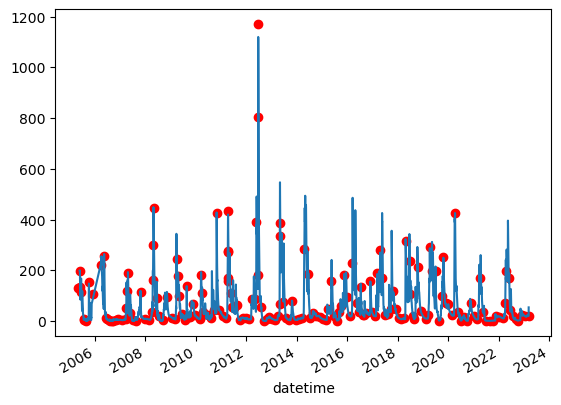

In [16]:
ax = fm.loc['04021520', 'discharge_va'].plot(lw=0, marker='o', color='r')
dvs['04021520']['Q'].plot(ax=ax)

### Get field measurements with channel data

In [17]:
fm = nwis.get_all_measurements(sites, data_format='rdb_expanded')
fm.head()

04021520
http://nwis.waterdata.usgs.gov/nwis/measurements?site_no=04021520&agency_cd=USGS&format=rdb_expanded


/Users/aleaf/Documents/GitHub/pydrograph/pydrograph/nwis.py:609: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  self.log = pd.concat([self.log,


agency_cd   site_no  measurement_nu  \
site_no  datetime                                                  
04021520 2005-04-27 12:11:00      USGS  04021520               1   
         2005-05-23 12:20:00      USGS  04021520               2   
         2005-05-26 14:51:00      USGS  04021520               3   
         2005-06-07 14:45:00      USGS  04021520               4   
         2005-07-22 12:50:00      USGS  04021520               5   

                                  measurement_dt tz_cd q_meas_used_fg  \
site_no  datetime                                                       
04021520 2005-04-27 12:11:00 2005-04-27 12:11:00   CDT            Yes   
         2005-05-23 12:20:00 2005-05-23 12:20:00   CDT            Yes   
         2005-05-26 14:51:00 2005-05-26 14:51:00   CDT            Yes   
         2005-06-07 14:45:00 2005-06-07 14:45:00   CDT            Yes   
         2005-07-22 12:50:00 2005-07-22 12:50:00   CDT            Yes   

                             party_nm site_visit_coll_agency_cd  \
site_no  datetime                                                 
04021520 2005-04-27 12:11:00  KGG/GRM                      USGS   
         2005-05-23 12:20:00  GRM/WWL                      USGS   
         2005-05-26 14:51:00  DLR/GRM                      USGS   
         2005-06-07 14:45:00      DLR                      USGS   
         2005-07-22 12:50:00      GRM                      USGS   

                              gage_height_va  discharge_va  ... chan_area  \
site_no  datetime                                           ...             
04021520 2005-04-27 12:11:00            4.19        129.00  ...      97.7   
         2005-05-23 12:20:00            4.22        135.00  ...     103.0   
         2005-05-26 14:51:00            5.01        199.00  ...     125.0   
         2005-06-07 14:45:00            3.91        113.00  ...      92.3   
         2005-07-22 12:50:00            1.61          5.82  ...      15.5   

                              chan_velocity  chan_stability chan_material  \
site_no  datetime                                                           
04021520 2005-04-27 12:11:00           1.32            UNSP          UNSP   
         2005-05-23 12:20:00           1.31            UNSP          UNSP   
         2005-05-26 14:51:00           1.59            UNSP          UNSP   
         2005-06-07 14:45:00           1.23            UNSP          UNSP   
         2005-07-22 12:50:00           0.38            UNSP          UNSP   

                             chan_evenness  long_vel_desc horz_vel_desc  \
site_no  datetime                                                         
04021520 2005-04-27 12:11:00          UNSP           unkn          UNSP   
         2005-05-23 12:20:00          UNSP           unkn          UNSP   
         2005-05-26 14:51:00          UNSP           unkn          UNSP   
         2005-06-07 14:45:00          UNSP           unkn          UNSP   
         2005-07-22 12:50:00          UNSP           unkn          UNSP   

                             vert_vel_desc chan_loc_cd chan_loc_dist  
site_no  datetime                                                     
04021520 2005-04-27 12:11:00          UNSP        UNSP           NaN  
         2005-05-23 12:20:00          UNSP        UNSP           NaN  
         2005-05-26 14:51:00          UNSP        UNSP           NaN  
         2005-06-07 14:45:00          UNSP        UNSP           NaN  
         2005-07-22 12:50:00          UNSP        UNSP           NaN  

[5 rows x 32 columns]